# 180. 영화평 Text 분류 - Sentiment Analysis

- IMDB (Internet Movie Database, https://www.imdb.com/)  Dataset


- 각 25,000 개의 training/testing set 으로 구성된 IMDB 영화관람평  


- “imdb_reviews” – encoding 되어있지 않은 string 형태의 data  


- label : positive, negative binary classification

## imbd_reviews (string data) 이용 감성 (이진) 분류

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
import numpy as np

In [2]:
dataset, info = tfds.load('imdb_reviews', with_info=True,as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteWQ2N6K/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteWQ2N6K/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteWQ2N6K/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


**tfds 는 tf.Tensor 반환**

In [3]:
for input, label in dataset['test']:
    print(label)
    print()
    print(input)
    break

tf.Tensor(1, shape=(), dtype=int64)

tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(),

## keras.preprocessing module 을 이용하여 tokenize 및 padding
- keras.preprocessing.text.Tokenizer  

- keras.preprocessing.sequence.pad_sequence

In [4]:
train_sentences = []
train_labels = []

test_sentences = []
test_labels = []

In [5]:
for sent, label in train_dataset:
    train_sentences.append(str(sent.numpy()))
    train_labels.append(label.numpy())

In [6]:
print(train_labels[-1])
print(train_sentences[-1])

1
b'First of all, Riget is wonderful. Good comedy and mystery thriller at the same time. Nice combination of strange \'dogma\' style of telling the story together with good music and great actors. But unfortunately there\'s no \'the end\'. As for me it\'s unacceptable. I was thinking... how it will be possible to continue the story without Helmer and Drusse? ...and I have some idea. I think Lars should make RIGET III a little bit different. I\'m sure that 3rd part without Helmer wouldn\'t be the same. So here\'s my suggestion. Mayble little bit stupid, maybe not. I know that Lars likes to experiment. So why not to make small experiment with Riget3? I think the only solution here is to create puppet-driven animation (like for example "team America" by Trey Parker) or even computer 3d animation. I know it\'s not the same as real actors, but in principle I believe it could work... only this way it\'s possible to make actors alive again. For Riget fans this shouldn\'t be so big difference 

In [7]:
for sent, label in test_dataset:
    test_sentences.append(str(sent.numpy()))
    test_labels.append(label.numpy())

In [8]:
print(test_labels[-1])
print(test_sentences[-1])

1
b"They just don't make cartoons like they used to. This one had wit, great characters, and the greatest ensemble of voice over artists ever assembled for a daytime cartoon show. This still remains as one of the highest rated daytime cartoon shows, and one of the most honored, winning several Emmy Awards."


## train_labels, test_labels 를 Python list 에서 numpy array 로 변환

In [9]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

print(train_labels.shape)
print(test_labels.shape)

(25000,)
(25000,)


## train_sentences, test_sentences text 를 sequence 로 변환 

In [10]:
vocab_size = 10000

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(train_sentences)

In [11]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

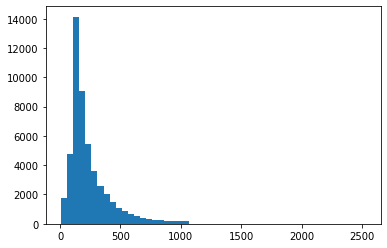

In [12]:
import matplotlib.pyplot as plt

plt.hist([len(s) for s in train_sequences] + [len(s) for s in test_sequences], bins=50);

In [13]:
max_length = 150

train_padded = pad_sequences(train_sequences,maxlen=max_length, truncating='post', padding='post')


test_padded = pad_sequences(test_sequences,maxlen=max_length, truncating='post', padding='post')

In [14]:
print(train_padded.shape)
print(test_padded.shape)
print(train_padded[0])

(25000, 150)
(25000, 150)
[  59   12   14   35  439  400   18  174   29    1    9   33 1378 3401
   42  496    1  197   25   88  156   19   12  211  340   29   70  248
  213    9  486   62   70   88  116   99   24 5740   12 3317  657  777
   12   18    7   35  406 8228  178 2477  426    2   92 1253  140   72
  149   55    2    1 7525   72  229   70 2962   16    1 2880    1    1
 1506 4998    3   40 3947  119 1608   17 3401   14  163   19    4 1253
  927 7986    9    4   18   13   14 4200    5  102  148 1237   11  240
  692   13   44   25  101   39   12 7232    1   39 1378    1   52  409
   11   99 1214  874  145   10    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


## sequence data 를 sentence 로 reverse conversion

In [15]:
def decode_review(text):
    return ' '.join([tokenizer.index_word.get(i, '<pad>') for i in text])

decode_review(train_padded[0])

print(decode_review(train_padded[0]))
print()
print(train_sentences[0])

b this was an absolutely terrible movie don't be <OOV> in by christopher walken or michael <OOV> both are great actors but this must simply be their worst role in history even their great acting could not redeem this movie's ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the <OOV> rebels were making their cases for <OOV> maria <OOV> <OOV> appeared phony and her pseudo love affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining <OOV> like christopher <OOV> good name i could barely sit through it <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but 

## model define

In [16]:
model = tf.keras.Sequential([
    Embedding(vocab_size+1, 64),
    Bidirectional(tf.keras.layers.LSTM(64)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640064    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 714,433
Trainable params: 714,433
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640064    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 714,433
Trainable params: 714,433
Non-trainable params: 0
_________________________________________________________________


In [18]:
num_epochs = 5
history = model.fit(train_padded, train_labels, epochs=num_epochs, batch_size=128,
          validation_data=(test_padded, test_labels), verbose=1)

Epoch 1/5
196/196 [==============================] - 20s 102ms/step - loss: 0.4663 - accuracy: 0.7648 - val_loss: 0.3807 - val_accuracy: 0.8315
Epoch 2/5
196/196 [==============================] - 19s 98ms/step - loss: 0.2670 - accuracy: 0.8960 - val_loss: 0.3955 - val_accuracy: 0.8352
Epoch 3/5
196/196 [==============================] - 19s 98ms/step - loss: 0.2111 - accuracy: 0.9223 - val_loss: 0.4375 - val_accuracy: 0.8270
Epoch 4/5
196/196 [==============================] - 19s 99ms/step - loss: 0.1587 - accuracy: 0.9423 - val_loss: 0.4958 - val_accuracy: 0.8163
Epoch 5/5
196/196 [==============================] - 19s 99ms/step - loss: 0.1274 - accuracy: 0.9562 - val_loss: 0.5303 - val_accuracy: 0.8015


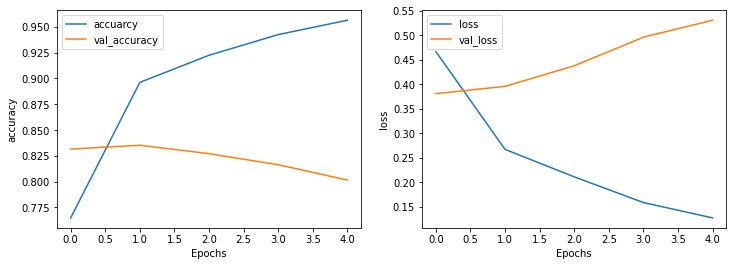

In [19]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('Epochs')
ax1.set_ylabel('accuracy')
ax1.legend(['accuarcy', 'val_accuracy'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('Epochs')
ax2.set_ylabel('loss')
ax2.legend(['loss', 'val_loss'])
plt.show()

In [24]:
#sample_text = ['The movei was terrible. I would recommend the movie']
#sample_text = ['The movei was fantastic. I would recommend the movie']
sample_text = ['The animation and graphics were out of this world']
sample_seq = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_seq, maxlen=max_length, padding='post', truncating='post')
sample_padded

array([[   2,  756,    3, 2888,   72,   46,    5,   12,  179,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [25]:
model.predict([sample_padded])

array([[0.6762674]], dtype=float32)